Ion Beam
========

In this notebook, we address the question of the stability of two populations of protons streaming one respect to the other along the local magnetic ﬁeld, a situation often encountered in collisionless plasmas. As we shall see, nature and strength of the instability varies with the plasma parameters (density, magnetic ﬁeld strength, relative velocity, temperature, ...).

In general, an instability arises if a mode exists with phase speed such as to be able
to increase its amplitude by taking the kinetic energy from the beam particles. For
this to happen, phase velocity and beam velocity must be quasi-equal in which case
the mode is said to resonates with the beam.

In [2]:
root_path  = "/home/user/PHARE/fluid_kinetic_class/2024/run/beam"
phare_path = "/home/user/PHARE/"

In [3]:
import os
import sys
phare_root = os.path.expanduser(phare_path)
sys.path.append(os.path.join(phare_root, "pyphare"))
sys.path.append(os.path.join(phare_root, "fluid_kinetic_class/2024"))

from pyphare.pharesee.run import Run
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as gf
from numpy import polyfit
from scipy.signal import find_peaks
from pyphare.pharesee.hierarchy import get_times_from_h5
from scipy.optimize import curve_fit
%matplotlib widget

# Electrostatic case

A particular example of beam instability is the one involving the ion-acoustic mode. This mode is a plasma equivalent of the standard acoustic mode in a compressible gas. Its phase speed is

$$
\left(\frac{\omega}{k} \right)^2 = c_s^2 = \frac{T_e + 3T_p}{m_p}
$$

in a proton-electron plasma. The very fact that the phase speed does not depend on the magnetic ﬁeld, suggest that the mode is a purely electrostatic one, not associated with ﬂuctuations of the magnetic ﬁeld. As already anticipated a beam of protons is potentially
unstable if the phase speed of a plasma mode is roughly the same as the beam velocity. To be more precise, a mode can grow (and be unstable) if its phase speed falls in the velocity interval where the slope of the beam distribution function is positive as shown in the next ﬁgure for the case of the ion acoustic mode with phasespeed $\omega/k = c_s$.

For this first electrostatic case, we consider 2 ion populations that we call `main' and ``beam` :
* for the `main` population, $n_m = 1.0$, $U_m = 0.0$ and $T_m = 0.025$
* for the `beam` population, $n_b = 0.1$, $U_b = 0.7$ and $T_b = 0.025$

The density and pressure of the beam are 0.1 of the values in the main which implies that the ion acoustic propagation speed is essentially given by the main plasma, i.e. $c_s = \sqrt{}T_e + 3 T_m \sim 0.57$

Note that in the simulation (in order to improve statistics for the beam particles) the same number of particles has been used for core and beam. Given that $n_b / n_m = 0.1$, the statistical weight of a main particle is 10 times that of a beam particle.

# Goal

We suggest in this section a single run, but you can the play with both `electron` and `main` temperatures to check the results... But the most unstable mode is the one for which $\gamma(k)$ is maximum. The best way to see this mode is then to have a box length $L_x = 2\pi/k_{\max}$. Hence, playing with $T_e$ and/or $T_m$ is not that simple...

# Run PHARE

- Open a terminal (File>New>Terminal)
- execute `pwd`, you should see `/home/user/PHARE` indicating you're in the PHARE directory
- execute `git clone https://github.com/PHAREHUB/fluid_kinetic_class`
- execute `cd fluid_kinetic_class/2024/run/beam/`


In there you will see a script called `ib1.py` that will configure a PHARE simulation for you.\
To run it, do:

```bash
python3 ib1.py
```

This should run and produce outputs in the directory:

- `ib1/`


To run the analysis for a specific run you did, execute cells below.

In [ ]:
path = root_path+"/"+"ib1"
r = Run(path)

In [ ]:
time=0
main = r.GetParticles(time, ["main",])

# Electrostatic case

In [ ]:
from scripts import dist_plot

In [ ]:
zob = dist_plot(main, axis=("x", "Vx"))

# Electromagnetic case

In [ ]:
path = root_path+"/"+"ib2"
r = Run(path)

In [ ]:
time=90
all_part = r.GetParticles(time, ["main", "beam"])

In [ ]:
sp_all = dist_plot(all_part, axis=("x", "Vx"), plot_type="scatter")

## Find the growth rate of the most unstable mode

In [68]:
def yaebx(x, a, b):
    return a * np.exp(np.multiply(b, x))

In [69]:
def growth_b_right_hand(run_path, time_offset):
    file = os.path.join(run_path, "EM_B.h5")
    times = get_times_from_h5(file)
    dt = times[1] - times[0]
    r = Run(run_path)
    first_mode = np.array([])

    for time in times:
        B_hier = r.GetB(time, merged=True, interp="linear")

        by_interpolator, xyz_finest = B_hier["By"]
        bz_interpolator, xyz_finest = B_hier["Bz"]

        # remove the last point so that "x" is periodic wo. last point = first point
        x = xyz_finest[0][:-1]

        by = by_interpolator(x)
        bz = bz_interpolator(x)

        # get the mode 1, as it is the most unstable in a box of length 33
        mode1 = np.absolute(np.fft.fft(by - 1j * bz)[1])
        first_mode = np.append(first_mode, mode1)

    ioffset = int(time_offset / dt)
    imax = find_peaks(first_mode, width=ioffset)[0][0]

    # the curve_fit is performed from time index 0 to imax-ioffset as this offset prevent to use
    # the final part of the curve which is no more exponential as this is the end of the linear mode
    popt, pcov = curve_fit(
        yaebx, times[: imax - ioffset], first_mode[: imax - ioffset], p0=[0.08, 0.09]
    )

    # now the signal is stripped from its exponential part
    damped_mode = first_mode[: imax - ioffset] * yaebx(
        times[: imax - ioffset], 1 / popt[0], -popt[1]
    )

    # find the omega for which "damped_mode" is the largest :
    # this term is twice the one it should be because "mode1" resulting from
    # an absolute value, this (cosx)^2 = cos(2x) then appears at the 2nd
    # harmonoic (hence the factor 0.5 to get "omega")
    # the factor "+1" is because we remove the DC component, so the value
    # given by argmax has also to miss this value
    omegas = np.fabs(np.fft.fft(damped_mode).real)
    omega = (
        0.5
        * (omegas[1 : omegas.size // 2].argmax() + 1)
        * 2
        * np.pi
        / times[imax - 1 - ioffset]
    )

    return times, first_mode, popt[0], popt[1], damped_mode, omega

In [70]:
def phase_space(time, r, **kwargs):
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
    
    vmin, vmax = kwargs.get("vmin", -1.2), kwargs.get("vmin", 7.6)
    
    t=time
    
    ions = r.GetParticles(t, ["main", "beam"])
    
    ions.dist_plot(
        axis=("x", "Vx"),
        ax=ax1,
        norm=0.4,
        finest=True,
        gaussian_filter_sigma=(1, 1),
        vmin=vmin,
        vmax=vmax,
        dv=0.05,
        title="t = {:.1f}".format(t),
        xlabel="",
        ylabel="",
    )
    ax1.set_xlim((0, 33))
    
    ax2 = ax1.twinx()
    
    E_hier = r.GetE(time=t, merged=True, interp="linear")
    ey_interpolator, xyz_finest = E_hier["Ey"]
    ax2.plot(
        xyz_finest[0],
        ey_interpolator(xyz_finest[0]),
        linewidth=2,
        color="dimgray",
    )
    ax2.set_ylim((-0.4, 0.4))
    
    ax2.set_ylabel("Ey(x)")
    ax1.set_ylabel("Vx - Velocity")
    ax1.set_xlabel("X - Position")

In [71]:
time_offset = 10.0

this is an offset so the exponential fit associated to the linear phase is not performed until the time at which the B value gets the greater... but is rather before with an offset given by `time_offset` : the exponential fit is performed on `[0, times[imax] - time_offset]`

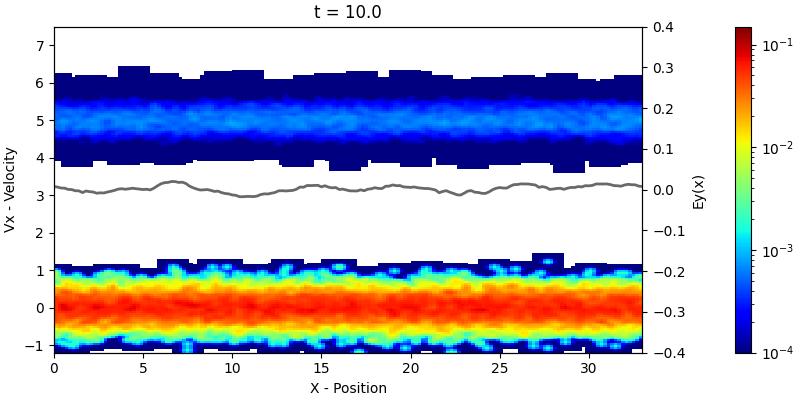

In [72]:
phase_space(10, r)

In [73]:
times, first_mode, ampl, gamma, damped_mode, omega = growth_b_right_hand(path, time_offset)

In [154]:
print("omega = ", omega)
k = 2*np.pi/r.GetDomainSize()[0]
print("k = ", k)
print("phase velocity = ", omega/k)

omega =  0.26071308328546
k =  0.19039955476301776
phase velocity =  1.3692946058091287


In [74]:
def growth_plot(r, **kwargs):
    file = os.path.join(r.path, "EM_B.h5")
    times = get_times_from_h5(file)
    dt = times[1] - times[0]
    imax = find_peaks(first_mode, width=int(10 / dt))[0][0]  # the smallest width of the peak is 10
    
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
    
    ax1.set_title("Time evolution of the first right-hand circular mode amplitude")
    ax1.plot(
        times,
        first_mode,
        color="k",
        label="|$\hat{B}_y (m=1,t)-i\hat{B}_z (m=1,t)$|",
    )
    ax1.plot(
        times[:imax],
        yaebx(times[:imax], ampl, gamma),
        color="r",
        linestyle="-",
        label="$B_0. \exp(\gamma t), \ with\ \gamma =${:5.5f} (expected 0.09)".format(
            gamma
        ),
    )
    ax1.axvline(0, 0, yaebx(times[imax], ampl, gamma), color="red", linestyle="--")
    ax1.axvline(
        times[imax] - time_offset,
        0,
        yaebx(times[imax], ampl, gamma),
        color="red",
        linestyle="--",
    )
    ax1.legend()
    ax1.set_xlabel("t - Time")

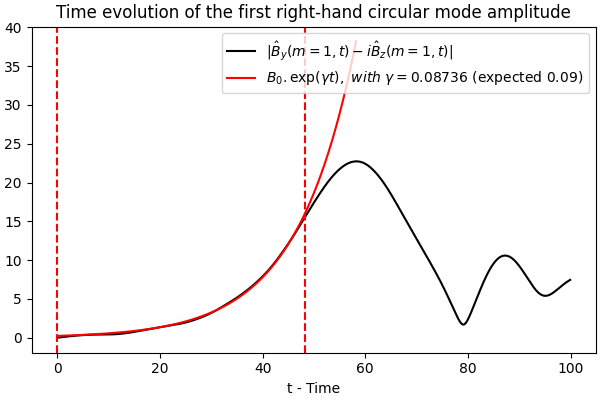

In [75]:
growth_plot(r)

## Build hodograms

In [133]:
path = root_path+"/"+"ib2"
r = Run(path)

In [134]:
time_a=50
B = r.GetB(time_a, merged=True)

In [135]:
by_, x_ = B["By"]
bz_, x_ = B["Bz"]

In [136]:
x_a = x_[0]
by_a = by_(x)
bz_a = bz_(x)

Text(0, 0.5, 'B component')

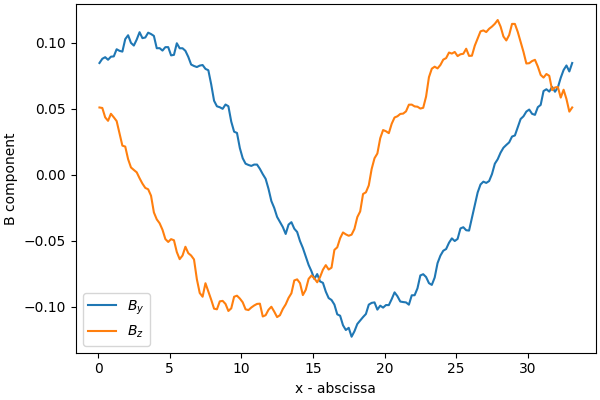

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)

ax.plot(x_a, by_a, label="$B_y$")
ax.plot(x_a, bz_a, label="$B_z$")

ax.legend()
ax.set_xlabel("x - abscissa")
ax.set_ylabel("B component")

In [147]:
time_b=60
B = r.GetB(time_b, merged=True)

In [148]:
by_, x_ = B["By"]
bz_, x_ = B["Bz"]

In [149]:
x_b = x_[0]
by_b = by_(x)
bz_b = bz_(x)

Text(0, 0.5, 'B component')

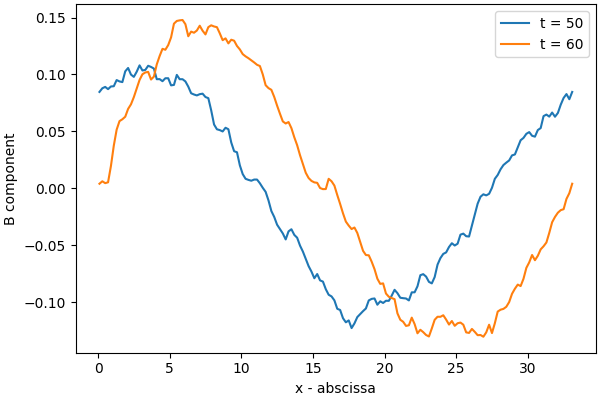

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)

ax.plot(x_a, by_a, label=f"t = {time_a}")
ax.plot(x_b, by_b, label=f"t = {time_b}")

ax.legend()
ax.set_xlabel("x - abscissa")
ax.set_ylabel("B component")

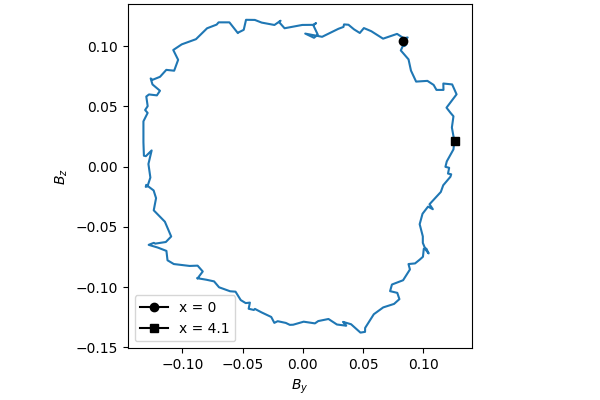

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)

ax.plot(by, bz)

ax.plot(by[0], bz[0], marker="o", label="x = 0", color="k")
ax.plot(by[20], bz[20], marker="s", label=f"x = {x[20]}", color="k")

ax.legend()
ax.set_xlabel("$B_y$")
ax.set_ylabel("$B_z$")
ax.set_aspect("equal")